# Применение метода фрактальной сигнатуры

Источники:

- [Довольно понятно объяснено, что мы делаем, и что это за "покрывала"](https://www.researchgate.net/publication/259695438_Application_of_the_Modified_Fractal_Signature_Method_for_Terrain_Classification_from_Synthetic_Aperture_Radar_Images)
- [Статья от Ампиловой](https://drive.google.com/open?id=1_gSwKN7Gt_i2qTQ9ThOgkzglllp6Tq-H)

In [186]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import generic_filter, generate_binary_structure

Загружаем картинку

Можно любую свою, только надо, чтобы она была в Gray scale, i guess

In [4]:
im = Image.open('silver/small.jpg')


def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [1/3, 1/3, 1/3])


imar = rgb2gray(np.array(im))

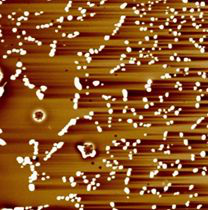

In [5]:
im

In [6]:
imar = np.array(im, dtype=np.int16)

In [7]:
imar.shape

(210, 208, 3)

In [9]:
imar[0:100]

array([[[ 86,  49,  40],
        [ 92,  54,  45],
        [220, 177, 171],
        ...,
        [ 60,   8,  12],
        [ 72,   0,  15],
        [ 92,   0,  33]],

       [[250, 211, 196],
        [180, 138, 124],
        [ 95,  51,  40],
        ...,
        [ 60,  11,  17],
        [ 77,   3,  28],
        [ 93,   3,  38]],

       [[255, 245, 223],
        [255, 218, 197],
        [116,  69,  51],
        ...,
        [ 45,   3,   7],
        [ 48,   0,   1],
        [ 66,   0,  13]],

       ...,

       [[ 95,  39,  40],
        [ 58,   2,   3],
        [ 56,   0,   0],
        ...,
        [ 50,   0,   0],
        [ 50,   0,   0],
        [ 53,   0,   0]],

       [[ 55,   0,   0],
        [ 53,   0,   0],
        [ 68,   4,   4],
        ...,
        [ 53,   0,   4],
        [ 63,   3,  15],
        [ 60,   0,  12]],

       [[ 73,   9,   7],
        [ 69,   5,   3],
        [ 75,   7,   4],
        ...,
        [ 61,   0,   0],
        [ 73,  11,  12],
        [ 63,   3,   3]]

In [10]:
imar[::2]

array([[[ 86,  49,  40],
        [ 92,  54,  45],
        [220, 177, 171],
        ...,
        [ 60,   8,  12],
        [ 72,   0,  15],
        [ 92,   0,  33]],

       [[255, 245, 223],
        [255, 218, 197],
        [116,  69,  51],
        ...,
        [ 45,   3,   7],
        [ 48,   0,   1],
        [ 66,   0,  13]],

       [[187, 135,  95],
        [148,  94,  56],
        [105,  49,  12],
        ...,
        [ 81,  51,  15],
        [ 63,  16,   0],
        [ 70,  13,   0]],

       ...,

       [[ 94,   7,   0],
        [ 92,   5,   0],
        [ 87,   2,   0],
        ...,
        [ 74,   9,   0],
        [ 88,  19,   0],
        [ 89,  18,   0]],

       [[ 82,   1,   0],
        [ 83,   4,   0],
        [ 81,   6,   3],
        ...,
        [ 61,   0,   4],
        [ 69,   0,   8],
        [ 71,   0,   9]],

       [[ 99,  24,   0],
        [108,  52,  19],
        [132,  99,  66],
        ...,
        [102,  27,   8],
        [104,  29,  10],
        [104,  29,  10]]

In [187]:
from scipy.ndimage.filters import maximum_filter, minimum_filter, generic_filter

Начинаем с того, что:
- $\delta = [1, d] -$по факту, просто шаг
- $u_0 = b_0 = $исходной марице

Вот хорошая иллюстрация одеяла, которое мы строим. Картинку спер из первой статьи

![blanket](images/blanket.png)

Вот, что надо посчитать итеративно:

$$u_{\delta}(i, j) = max\{u_{\delta - 1}(i, j) + 1, \underset{|(m,n) - (x,y)| \le 1}{max} u_{\delta-1}(m,n) \}$$

$$b_{\delta}(i, j) = min\{b_{\delta - 1}(i, j) - 1, \underset{|(m,n) - (x,y)| \le 1}{min} b_{\delta-1}(m,n) \}$$

В результате, можно посчитать объем на шаге $\delta$ следующим образом:

$$Vol_{\delta} = \sum (u_{\delta}(i, j) - b_{\delta}(i, j))$$

## Говнокодерский способ

In [1]:
%%time
u = imar.copy()
b = imar.copy()

ds = range(1, 100)
vols = []

for d in ds:
#     un = u.copy()
#     bn = b.copy()
      u_dd = u.copy()
      b_dd = b.copy()
#     u_dd = np.pad(u, 1, 'constant', constant_values=0)
#     b_dd = np.pad(b, 1, 'constant', constant_values=255)
    
    for i in range(1, imar.shape[0]+1):
        for j in range(1, imar.shape[1]+1):
            
            u_dp1 = np.max([ u_dd[i-1, j-1], u_dd[i, j-1], u_dd[i+1, j+1],
                            u_dd[i-1, j], u_dd[i, j] + 1, u_dd[i+1, j],
                            u_dd[i-1, j+1], u_dd[i, j+1], u_dd[i+1, j-1]
                           ])
            b_dm1 = np.min([ b_dd[i-1, j-1], b_dd[i, j-1], b_dd[i+1, j+1],
                            b_dd[i-1, j], b_dd[i, j] - 1, b_dd[i+1, j],
                            b_dd[i-1, j+1], b_dd[i, j+1], b_dd[i+1, j-1]
                           ])
            

            un[i-1, j-1] = u_dp1
            bn[i-1, j-1] = b_dm1
            
    
    u = un
    b = bn
    vols.append((np.sum(u - b))/2)

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 15)

In [85]:
vols

[10721925.0,
 12720291.0,
 13925266.5,
 14823193.5,
 15528342.0,
 16079178.0,
 16512394.5,
 16855575.0,
 17138536.5,
 17378470.5,
 17587851.0,
 17775220.5,
 17947957.5,
 18110935.5,
 18264931.5,
 18411597.0,
 18551620.5,
 18687256.5,
 18822075.0,
 18955423.5,
 19086955.5,
 19217995.5,
 19349035.5,
 19480075.5,
 19611115.5,
 19742155.5,
 19873195.5,
 20004235.5,
 20135275.5,
 20266315.5,
 20397355.5,
 20528395.5,
 20659435.5,
 20790475.5,
 20921515.5,
 21052555.5,
 21183595.5,
 21314635.5,
 21445675.5,
 21576715.5,
 21707755.5,
 21838795.5,
 21969835.5,
 22100875.5,
 22231915.5,
 22362955.5,
 22493995.5,
 22625035.5,
 22756075.5,
 22887115.5,
 23018155.5,
 23149195.5,
 23280235.5,
 23411275.5,
 23542315.5,
 23673355.5,
 23804395.5,
 23935435.5,
 24066475.5,
 24197515.5,
 24328555.5,
 24459595.5,
 24590635.5,
 24721675.5,
 24852715.5,
 24983755.5,
 25114795.5,
 25245835.5,
 25376875.5,
 25507915.5,
 25638955.5,
 25769995.5,
 25901035.5,
 26032075.5,
 26163115.5,
 26294155.5,
 26425195.5,

## Реализация через векторизацию

In [189]:
%%time
u = imar.copy()
b = imar.copy()
neighborhood = generate_binary_structure(2,2)
# footprint=np.array([[0, 1, 0],
#                     [1, 0, 1],
#                     [0, 1, 0]])
ds = range(1, 30)
vols = []

for d in ds:
    fst_u = u + 1
    fst_b = b - 1

    scnd_u = maximum_filter(u, mode='wrap', footprint=neighborhood, cval=0)
    scnd_b = minimum_filter(b, mode='wrap', footprint=neighborhood, cval=255)

    u = np.maximum(fst_u, scnd_u)
    b = np.minimum(fst_b, scnd_b)
    
    vols.append((np.sum(u - b))/2)

RuntimeError: sequence argument must have length equal to input rank

In [114]:
vols

[131040.0,
 7084705.0,
 12118826.5,
 14168334.0,
 15718242.5,
 16737623.5,
 17276923.0,
 17563755.0,
 17726603.0,
 17865700.0,
 18002605.0,
 18138039.5,
 18272441.0,
 18406151.0,
 18539417.0,
 18672273.5,
 18804713.0,
 18936887.0,
 19068824.0,
 19200620.0,
 19332261.5,
 19463729.0,
 19595147.0,
 19726517.0,
 19857843.5,
 19989135.5,
 20120385.5,
 20251614.5,
 20382824.0,
 20513991.5,
 20645123.0,
 20776223.0,
 20907306.5,
 21038355.5,
 21169395.5,
 21300435.5,
 21431475.5,
 21562515.5,
 21693555.5,
 21824595.5,
 21955635.5,
 22086675.5,
 22217715.5,
 22348755.5,
 22479795.5,
 22610835.5,
 22741875.5,
 22872915.5,
 23003955.5,
 23134995.5,
 23266035.5,
 23397075.5,
 23528115.5,
 23659155.5,
 23790195.5,
 23921235.5,
 24052275.5,
 24183315.5,
 24314355.5,
 24445395.5,
 24576435.5,
 24707475.5,
 24838515.5,
 24969555.5,
 25100595.5,
 25231635.5,
 25362675.5,
 25493715.5,
 25624755.5,
 25755795.5,
 25886835.5,
 26017875.5,
 26148915.5,
 26279955.5,
 26410995.5,
 26542035.5,
 26673075.5,
 2

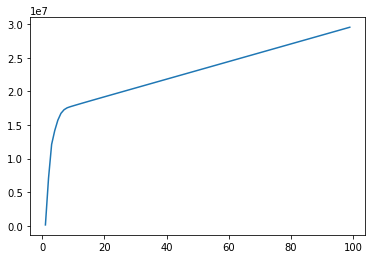

In [115]:
plt.plot(ds, vols)

# Зависимость объема от $\epsilon$

In [182]:
def fractal_signature(imar, d_=10):
    u = imar.copy()
    b = imar.copy()

    footprint=np.array([[0, 1, 0],
                        [1, 0, 1],
                        [0, 1, 0]])
    ds = range(1, d_)
    vols = []

    for d in ds:
        fst_u = u + 1
        fst_b = b - 1

        scnd_u = maximum_filter(u, mode='constant', size=d, cval=0)
        scnd_b = minimum_filter(b, mode='constant', size=d, cval=255)

        u = np.maximum(fst_u, scnd_u)
        b = np.minimum(fst_b, scnd_b)

        vols.append((np.sum(u - b)))
#         print((vols[-1] - vols[-2])/2)
        
#         h = (vols[-1] - vols[-2])/2
#         z.append(h)
    return (vols[-1] - vols[-2])/2

In [183]:
# a = 10
# result = []
# for i in range(a):
#     h = fractal_signature(imar, a)
#     result.append(h)
# plt.plot(a, result)

fractal_signature(imar, 200)


131040.0

In [122]:
ass_d300

[]

In [123]:
eps = 100

0 100
0 100


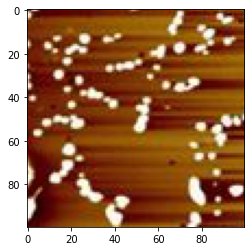

0 100
100 200


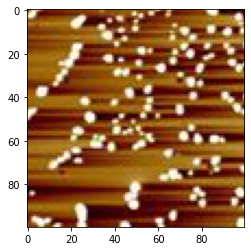

100 200
0 100


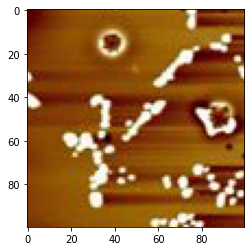

100 200
100 200


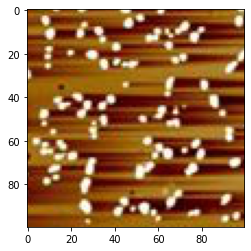

In [124]:
for start1, end1 in zip(range(0, imar.shape[0]-eps, eps), range(eps, imar.shape[0], eps)):
    for start2, end2 in zip(range(0, imar.shape[1]-eps, eps), range(eps, imar.shape[1], eps)):
        print(start1, end1)
        print(start2, end2)
        plt.imshow(imar[start1:end1, start2:end2])
        plt.show()

In [127]:
from progressbar import ProgressBar

In [ ]:
ass_d4 = []
ass_d10 = []
ass_d20 = []
ass_d50 = []
ass_d300 = []
epses = range(4, 30)

for eps in epses:
    ads4 = ads10 = ads20 = ads50 = ads300 = 0
#     bar = ProgressBar()
    for start1, end1 in zip(range(0, imar.shape[0]-eps, eps), range(eps, imar.shape[0], eps)):
        for start2, end2 in zip(range(0, imar.shape[1]-eps, eps), range(eps, imar.shape[1], eps)):
#             ads4 += fractal_signature(imar[start1:end1, start2:end2], 4)
#             ads10 += fractal_signature(imar[start1:end1, start2:end2], 10)
#             ads20 += fractal_signature(imar[start1:end1, start2:end2], 20)
#             ads50 += fractal_signature(imar[start1:end1, start2:end2], 20)
            ads300 += fractal_signature(imar[start1:end1, start2:end2], 300)
#     ass_d4.append(ads4)
#     ass_d10.append(ads10)
#     ass_d20.append(ads20)
#     ass_d50.append(ads50)
    ass_d300.append(ads300)

In [ ]:
# plt.plot(epses, ass_d4, label="d = 4")
# plt.plot(epses, ass_d10, label="d = 10")
# plt.plot(epses, ass_d20, label="d = 20")
# plt.plot(epses, ass_d50, label="d = 50")
plt.plot(range(4, 30), ass_d300, label="d = 300")
plt.legend()